In [20]:
%matplotlib inline
# notebook
import matplotlib.pylab as pylab
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.cluster import KMeans
from collections import Counter
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import networkx as nx
from math import sin, cos, sqrt, atan2, radians
#make the graphs bigger
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

In [21]:
data = pd.read_csv("eigg.csv") 
data.head()

C:\Users\davie\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (9,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,NBN Atlas record ID,Occurrence ID,Licence,Rightsholder,Scientific name,Common name,Species ID (TVK),Taxon Rank,Occurrence status,Start date,...,Class,Order,Family,Genus,OSGR 100km,OSGR 10km,OSGR 2km,OSGR 1km,Country,State/Province
0,baa00bca-011f-43bf-b3e2-4ea60f04646e,3783,CC-BY-NC,Buglife,Meloe violaceus,Violet Oil-beetle,NBNSYS0000024952,species,present,28/06/1905,...,Insecta,Coleoptera,Meloidae,Meloe,NM,NM48,NM48T,NM4686,United Kingdom,Scotland
1,f70cff95-1d0d-4dbd-bece-10239bad0a93,232100298,CC0,NaN,Rhantus suturellus,NaN,NBNSYS0000007613,species,present,11/09/1910,...,Insecta,Coleoptera,Dytiscidae,Rhantus,NM,NM48,NM48N,NM4486,United Kingdom,Scotland
2,f450fbce-7e45-4822-ada4-0591c7ea0b48,232100297,CC0,NaN,Gyrinus substriatus,NaN,NBNSYS0000007643,species,present,11/09/1910,...,Insecta,Coleoptera,Gyrinidae,Gyrinus,NM,NM48,NM48N,NM4486,United Kingdom,Scotland
3,e6ceb7fa-7437-490f-a93e-862872492660,232100292,CC0,NaN,Enochrus fuscipennis,NaN,NHMSYS0001718079,species,present,11/09/1910,...,Insecta,Coleoptera,Hydrophilidae,Enochrus,NM,NM48,NM48N,NM4486,United Kingdom,Scotland
4,e6649320-d64b-4c29-8393-5565655f0ff9,232100296,CC0,NaN,Boreonectes multilineatus,NaN,NHMSYS0021125444,species,present,11/09/1910,...,Insecta,Coleoptera,Dytiscidae,Boreonectes,NM,NM48,NM48N,NM4486,United Kingdom,Scotland


In [22]:
# technically doesnt count the fact the earth isnt a sphere
def seperationInMetres(p1,p2):
    R = 6373.0
    
    lat1,lon1 = p1
    lat2, lon2 = p2
    
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    #convert to metres
    return distance * 1000 

def withinInspectableArea(centroid, p1, maxDistanceAway):
    return seperationInMetres(p1,centroid) <= maxDistanceAway

In [23]:
centroid = (56.907887,-6.1960333) #Eigg central
maxDistance = 10000 # Take everything

df = data[['Recorder', 'Latitude (WGS84)', 'Longitude (WGS84)', 'Start date year']]

df = df.dropna(subset=['Latitude (WGS84)'])
df = df.dropna(subset=['Longitude (WGS84)'])
df["Latitude (WGS84)"] = df["Latitude (WGS84)"].astype(np.float32)
df["Longitude (WGS84)"] = df["Longitude (WGS84)"].astype(np.float32)

df = df.dropna(subset=['Start date year'])
df = df.dropna(subset=['Recorder'])
df["Start date year"] = df["Start date year"].astype(np.int32)
df = df[(df['Start date year'] > 2010.0)]

df = df[df.apply(lambda x: withinInspectableArea(centroid,(x['Latitude (WGS84)'],x['Longitude (WGS84)']),maxDistance), axis=1)]
print(len(df['Recorder'].unique()))

55


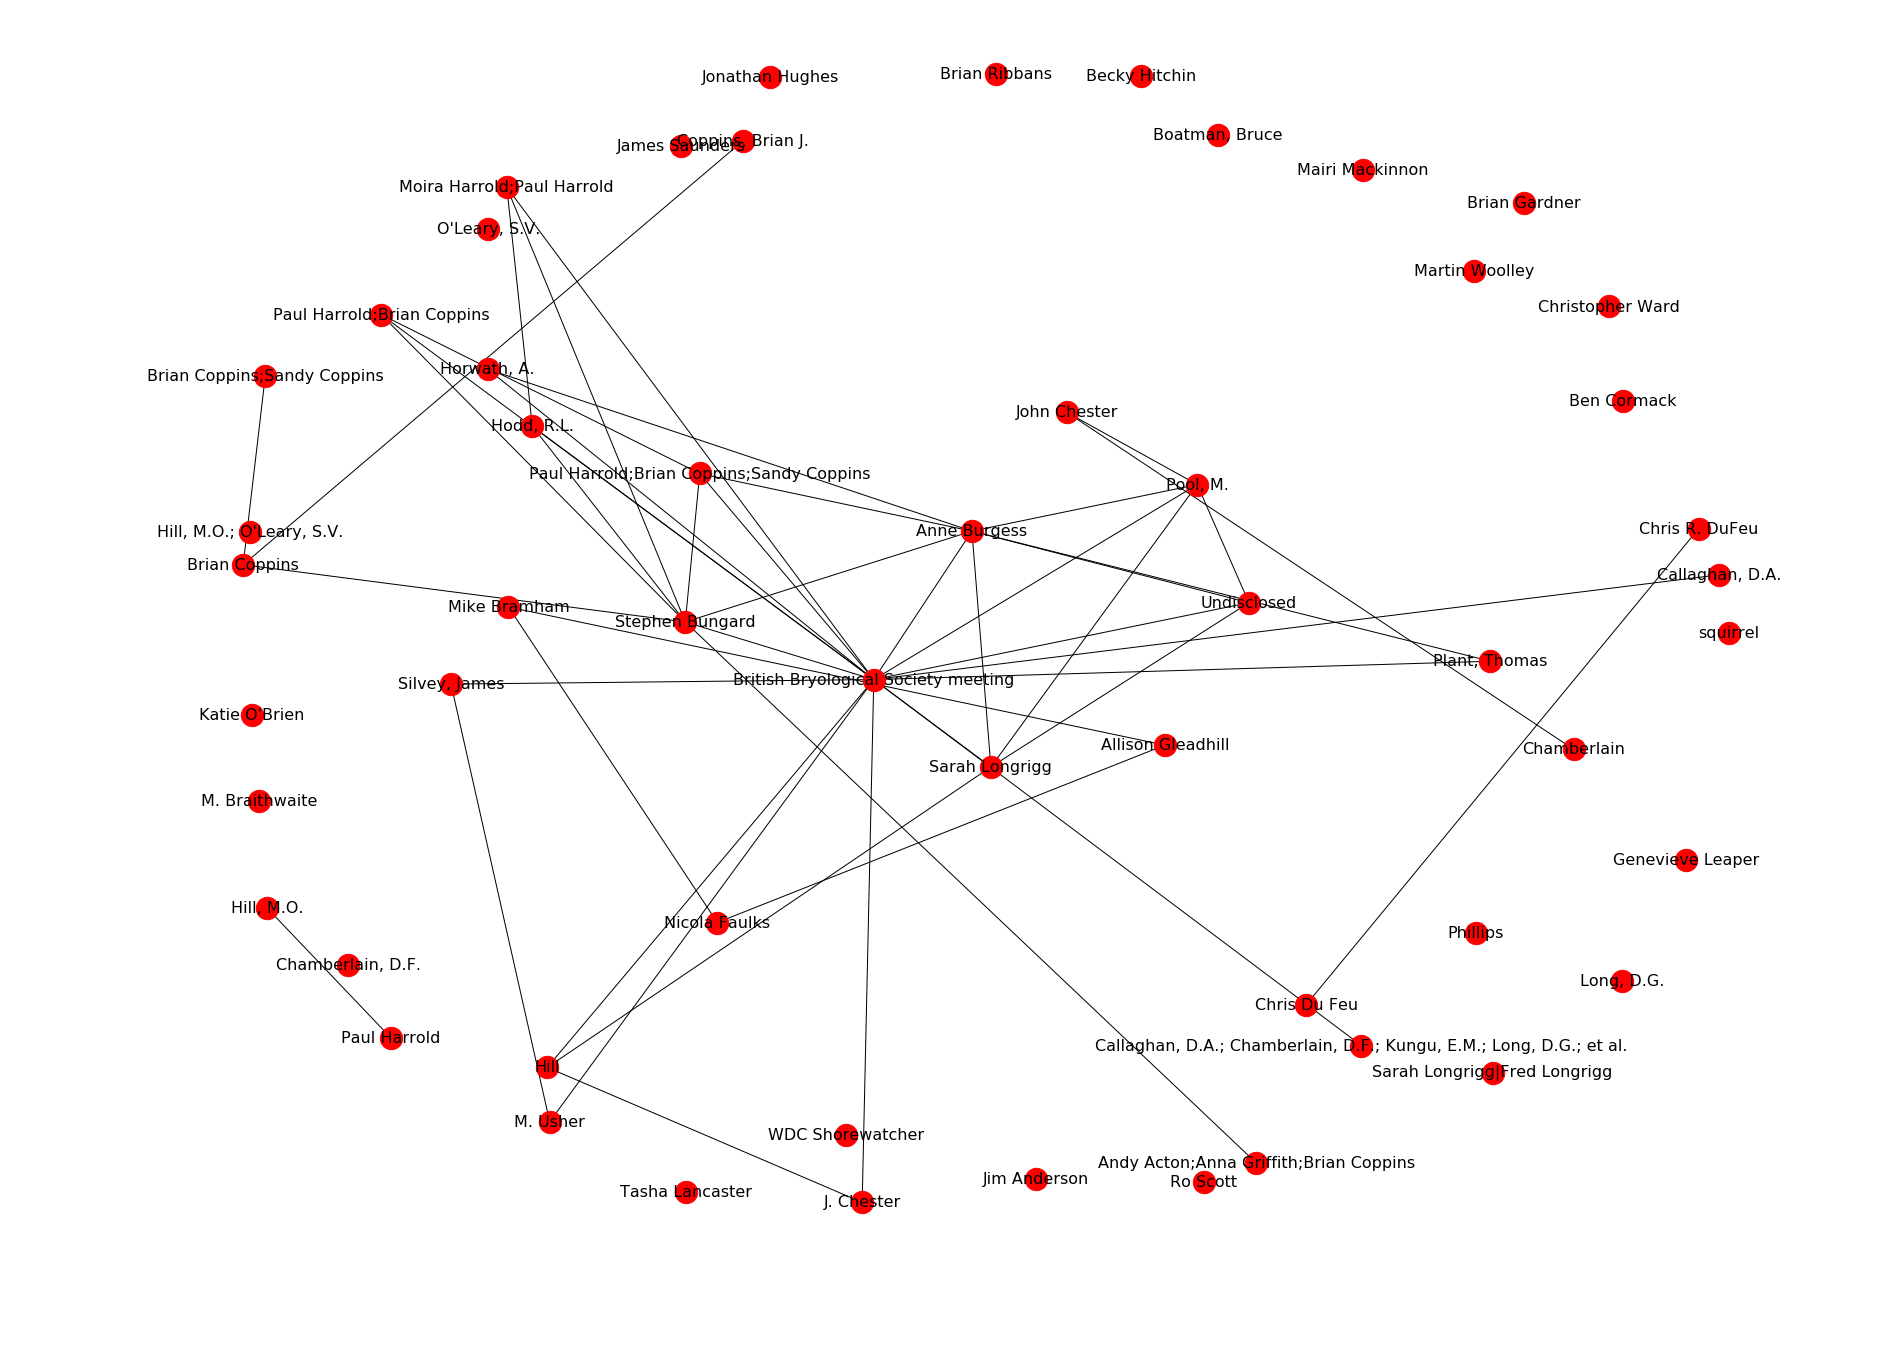

In [24]:
maxDist = 10 #anything within 100 metres observed is counted

def retrieveRecorders(df):
    return df['Recorder'].unique()

def retrieveRecorderLocations(df):
    recorders = retrieveRecorders(df)
    locs = {}
    for recorder in recorders:
        entries = df[df['Recorder'] == recorder]
        locations = zip(entries['Latitude (WGS84)'], entries['Longitude (WGS84)'])
        locations = set(locations)
        locs[recorder] = locations
    
    return locs

def recorderCloseTo(recorder, recorderLocs):
    currEntries = recorderLocs[recorder]
    remainder = recorderLocs.keys()
    ret = []
    for k,an in enumerate(remainder):
        if an != recorder:
            targetEntries = list(recorderLocs[an])
            breakYet = False
            for entry1 in currEntries:
                for entry2 in targetEntries:
                    if seperationInMetres(entry1,entry2) <= maxDist:
                        ret.append(k)
                        breakYet = True
                        break
                if breakYet:
                    break
    return ret

def buildGraph(df):    
    recorders = retrieveRecorders(df)
    
    G = nx.Graph()
    labels={}
    for k,i in enumerate(recorders): labels[k] = i
    
    for k,i in enumerate(recorders): G.add_node(k)
    recorderToLatLonMapping = retrieveRecorderLocations(df)
    for k,a in enumerate(recorders):
        closeTo = recorderCloseTo(a, recorderToLatLonMapping)
        for c in closeTo:
            G.add_edge(k,c)
    return G, labels

G, labels = buildGraph(df)
pos=nx.spring_layout(G,k=1)
nx.draw_networkx_labels(G,pos,labels,font_size=16)
nx.draw(G, pos, node_size=500)

In [25]:
file = nx.to_numpy_matrix(G)
print(file.shape)
print()
print(file)
np.savetxt("BasicSocialFile.txt",file, "%d")   

(55, 55)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
